# Mall Customers

Задача: Кластеризовать клиентов магазинов

In [1]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


загружаем выборку и смотрим ее структуру

In [2]:
data = pandas.read_csv("Mall_Customers.csv", na_values="NaN")

In [3]:
display(data.shape)
data.head(3)

(200, 5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


форматируем категориальный признак "Gender" для последующей работы

In [4]:
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})
data.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6


исследуем корреляцию данных

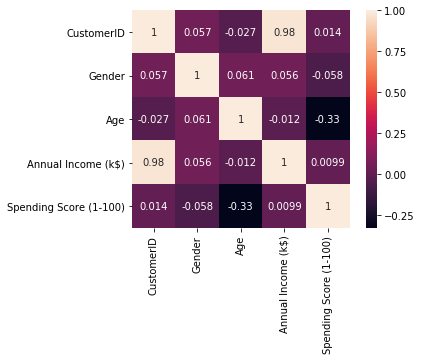

In [5]:
seaborn.heatmap(data.corr(), annot=True, square=True)

поскольку признаки "CustomerID" и "Annual Income (k$)" имеют практически линейную (0.98) степень корреляции, удаляем "CustomerID" как избыточный. 

In [6]:
data_1 = data.drop(["CustomerID"], axis=1)

In [7]:
data_1.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


#### Используя циклическое исполнение алгоритма кластеризации KMeans с увеличением количества выбираемых кластеров от 2 до 12 и коэффициент «силуэт» ищем количество кластеров.
* Алгоритм k-means (k-средних) разбивает множество элементов векторного пространства на заранее известное число кластеров k. Действие алгоритма таково, что он стремится минимизировать среднеквадратичное отклонение на точках каждого кластера. Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Алгоритм завершается, когда на какой-то итерации не происходит изменения кластеров. 
* коэффициент «силуэт» вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу. Силуэт вычисляется как (b - a) / max(a, b), где b — это расстояние между a и ближайшим кластером, в который a не входит. Можно вычислить среднее значение силуэта по всем образцам и использовать его как метрику для оценки количества кластеров.)

In [8]:
from sklearn.cluster import KMeans
# для расчета коэффициента "Силует" вызываем метод silhouette_score
from sklearn.metrics import silhouette_score

In [9]:
X_scaled = data_1

In [10]:
km_silhouette = []

for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Коэффициент Силует для {} кластеров: {}".format(i,silhouette))

Коэффициент Силует для 2 кластеров: 0.293073340055
Коэффициент Силует для 3 кластеров: 0.383798873822
Коэффициент Силует для 4 кластеров: 0.405295433064
Коэффициент Силует для 5 кластеров: 0.444066920474
Коэффициент Силует для 6 кластеров: 0.452054753808
Коэффициент Силует для 7 кластеров: 0.440964628774
Коэффициент Силует для 8 кластеров: 0.427772134576
Коэффициент Силует для 9 кластеров: 0.40091995116
Коэффициент Силует для 10 кластеров: 0.37867859304
Коэффициент Силует для 11 кластеров: 0.376869208824


#### Визуализируем результаты вычислений 

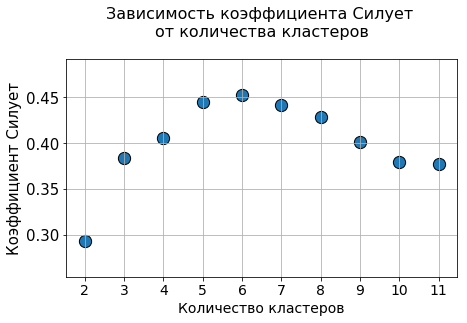

In [11]:
plt.figure(figsize=(7,4))
plt.title(u"Зависимость коэффициента Силует \nот количества кластеров\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel(u"Количество кластеров",fontsize=14)
plt.ylabel(u"Коэффициент Силует",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

наибольший коэффициент у алгоритма, который считает значение коэффициента "Силует" для 6 кластеров

#### Получаем вектор предсказания шести кластеров

In [12]:
km_6 = KMeans(n_clusters=6, random_state=0)
km_6.fit(X_scaled)
preds_6 = km_6.predict(X_scaled)

Для формирования аналитического отчета добавляем вектор предсказаний в выборку                                                  

In [13]:
KMeans_clastered_data = data

In [14]:
KMeans_clastered_data["Claster"] = preds_6
KMeans_clastered_data.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
0,1,1,19,15,39,5
1,2,1,21,15,81,4
2,3,0,20,16,6,5


#### Формируем аналитический отчет для бизнеса

In [15]:
for i in range(0, 6):
    cases = round(100*KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Claster[0]/KMeans_clastered_data.shape[0], 1)
    if KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Gender[1] > 0.5:
        gender = "мужчины"
    else:
        gender = "женщины"
    age_min = int(KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Age[1] - KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Age[2])
    age_max = int(KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Age[1] + KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe().Age[2])
    an_in = int(KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe()['Annual Income (k$)'][1])
    s_score = int(KMeans_clastered_data[KMeans_clastered_data["Claster"]==i].describe()['Spending Score (1-100)'][1])
    print " Кластер № {} составляет {}% от выборки. Преобладают {}. Возрастная группа в основном \
        в диапазоне от {} до {} лет. Среднегодовой доход составляет около {} тысяч долларов. \
        Средняя покупательская активность - {} баллов.".format(i, cases, gender, age_min, age_max, an_in, s_score)

 Кластер № 0 составляет 19.0% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 19 до 34 лет. Среднегодовой доход составляет около 56 тысяч долларов.         Средняя покупательская активность - 49 баллов.
 Кластер № 1 составляет 22.5% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 47 до 64 лет. Среднегодовой доход составляет около 53 тысяч долларов.         Средняя покупательская активность - 49 баллов.
 Кластер № 2 составляет 17.5% от выборки. Преобладают мужчины. Возрастная группа в основном         в диапазоне от 30 до 52 лет. Среднегодовой доход составляет около 88 тысяч долларов.         Средняя покупательская активность - 17 баллов.
 Кластер № 3 составляет 19.5% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 28 до 36 лет. Среднегодовой доход составляет около 86 тысяч долларов.         Средняя покупательская активность - 82 баллов.
 Кластер № 4 составляет 11.0% от выборки

#### Визуализируем данные, используя t-SNE алгоритм

* t-SNE (t-distributed stochastic neighbor embedding )— алгоритм нелинейного снижения размерности и визуализации многомерных данных.

In [16]:
from sklearn import manifold

In [17]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_1_2d_tsne = tsne.fit_transform(data_1)

для этого сворачиваем выборку до двух компонент и подсвечиваем кластера 

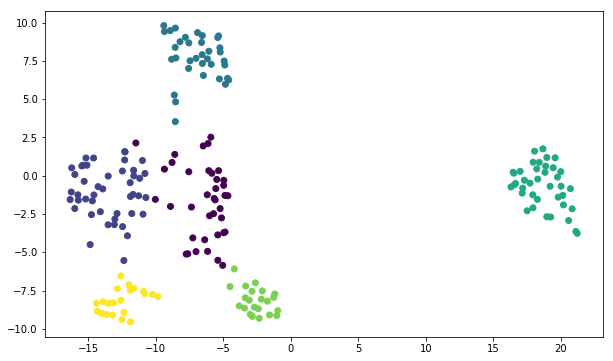

In [18]:
labels = preds_6
pylab.figure(figsize = (10, 6))
pylab.scatter(data_1_2d_tsne[:, 0], data_1_2d_tsne[:, 1], c=labels)

In [19]:
km_6_tsne = KMeans(n_clusters=6, random_state=0)
km_6_tsne.fit(data_1_2d_tsne)
preds_6_tsne = km_6_tsne.predict(data_1_2d_tsne)

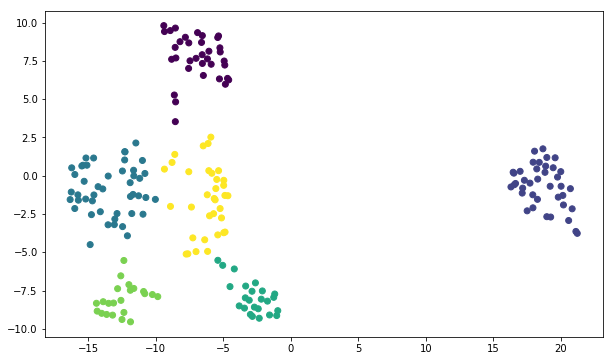

In [20]:
labels = preds_6_tsne
pylab.figure(figsize = (10, 6))
pylab.scatter(data_1_2d_tsne[:, 0], data_1_2d_tsne[:, 1], c=labels)

видим, что кластеризация принципиально не изменилась но стала несколько более четкой.

#### Решим задачу, используя методы иерархической кластеризации данных

* Иерархическая кластеризация (графовая кластеризация или иерархический кластерный анализ) — совокупность алгоритмов упорядочивания данных, направленных на создание иерархии (дерева) вложенных кластеров. Есть два класса методов иерархической кластеризации:

   Агломеративные - новые кластеры создаются путем объединения более мелких кластеров и, таким образом, дерево создается от листьев к стволу;
   Дивизионные - новые кластеры создаются путем деления более крупных кластеров на более мелкие и, таким образом, дерево создается от ствола к листьям.

In [22]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

Выполняем иерархическую / агломерационную кластеризацию

In [23]:
Z = linkage(data_1, 'ward')

создаем вектор предсказаний отнесения объектов к кластерам, при условии, что нам заранее известно количество кластеров

In [24]:
k=6
clasterization = fcluster(Z, k, criterion='maxclust')

визуализируем полученные данные

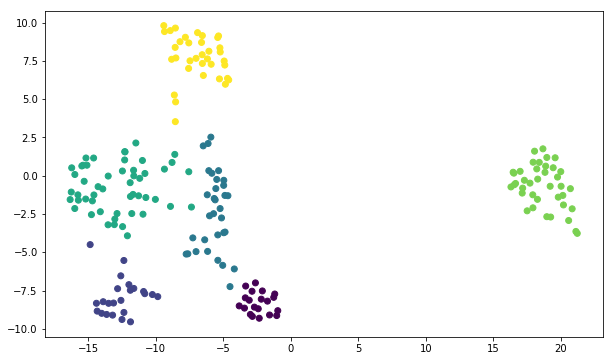

In [25]:
labels = clasterization
pylab.figure(figsize = (10, 6))
pylab.scatter(data_1_2d_tsne[:, 0], data_1_2d_tsne[:, 1], c=labels)

исследуем данные, нарисовав их полную дендрограмму

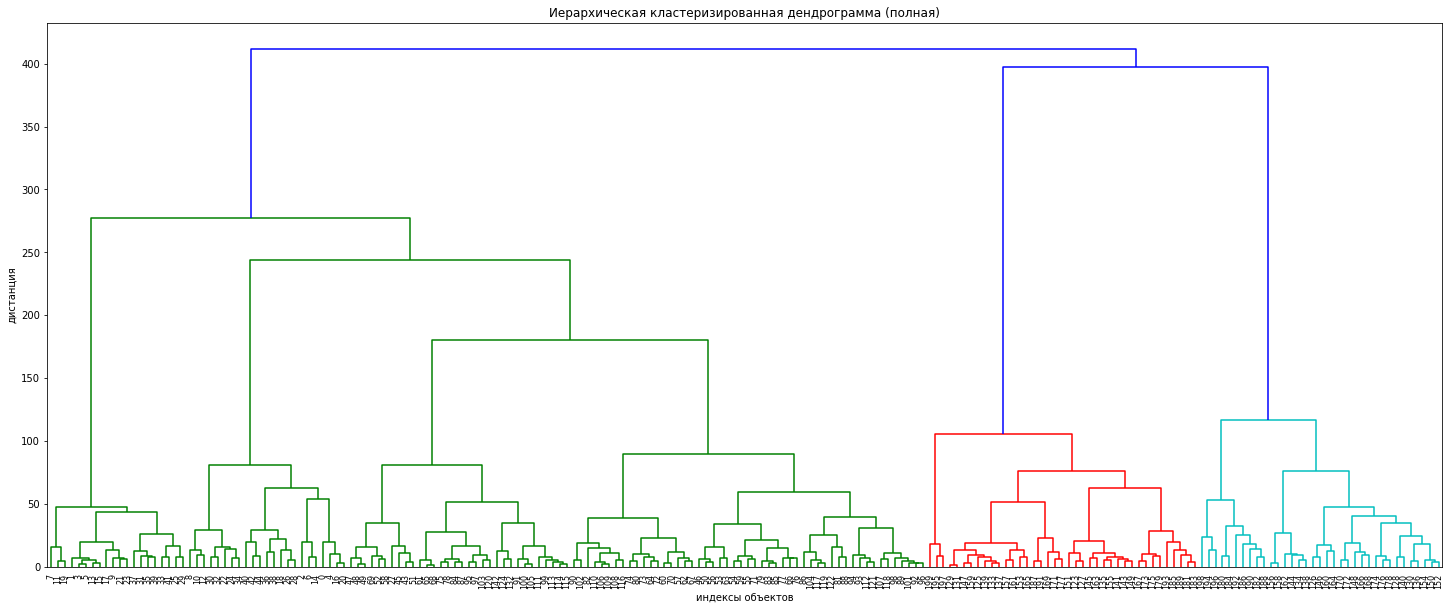

In [33]:
plt.figure(figsize=(25, 10))
plt.title(u'Иерархическая кластеризированная дендрограмма (полная)')
plt.xlabel(u'индексы объектов')
plt.ylabel(u'дистанция')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

наблюдаем, что действительно оптимально разделить выборку на шесть кластеров. делаем усеченную выборку.

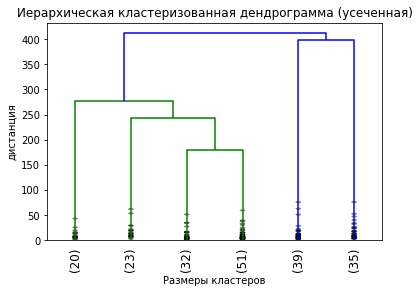

In [30]:
plt.title(u'Иерархическая кластеризованная дендрограмма (усеченная)')
plt.xlabel(u'Размеры кластеров')
plt.ylabel(u'дистанция')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

добавляем предсказание кластеров в выборку, интерпретируем данные для бизнеса, формируем их в  аналитический отчет

In [80]:
clastered_data = data

In [81]:
clastered_data["Claster"] = clasterization
clastered_data.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
0,1,1,19,15,39,2
1,2,1,21,15,81,1
2,3,0,20,16,6,2


In [105]:
clastered_data[clastered_data["Claster"]==1].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.0
mean,21.700000,0.400000,24.850000,24.950000,81.000000,1.0
std,12.653687,0.502625,5.029126,7.287155,9.514532,0.0
min,2.000000,0.000000,18.000000,15.000000,66.000000,1.0
25%,11.500000,0.000000,21.000000,19.000000,73.000000,1.0
50%,21.000000,0.000000,23.000000,23.500000,78.000000,1.0
75%,32.500000,1.000000,29.250000,30.750000,88.250000,1.0
max,42.000000,1.000000,35.000000,38.000000,99.000000,1.0


In [95]:
clastered_data[clastered_data["Claster"]==2].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,23.00000,23.000000,23.000000,23.000000,23.000000,23.0
mean,23.00000,0.391304,45.217391,26.304348,20.913043,2.0
std,13.56466,0.499011,13.228607,7.893811,13.017167,0.0
min,1.00000,0.000000,19.000000,15.000000,3.000000,2.0
25%,12.00000,0.000000,35.500000,19.500000,9.500000,2.0
50%,23.00000,0.000000,46.000000,25.000000,17.000000,2.0
75%,34.00000,1.000000,53.500000,33.000000,33.500000,2.0
max,45.00000,1.000000,67.000000,39.000000,40.000000,2.0


In [96]:
clastered_data[clastered_data["Claster"]==3].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,32.0000,32.000000,32.000000,32.000000,32.00000,32.0
mean,84.3750,0.375000,24.531250,54.187500,50.25000,3.0
std,30.1777,0.491869,4.964288,11.663114,8.29691,0.0
min,28.0000,0.000000,18.000000,28.000000,29.00000,3.0
25%,57.5000,0.000000,19.750000,45.250000,45.00000,3.0
50%,86.5000,0.000000,24.000000,55.500000,51.50000,3.0
75%,107.5000,1.000000,27.250000,62.250000,55.25000,3.0
max,143.0000,1.000000,35.000000,76.000000,65.00000,3.0


In [98]:
clastered_data[clastered_data["Claster"]==4].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,85.568627,0.411765,53.215686,55.117647,49.470588,4.0
std,21.677873,0.497050,10.461957,7.981596,6.070759,0.0
min,47.000000,0.000000,32.000000,40.000000,40.000000,4.0
25%,67.500000,0.000000,47.000000,48.000000,44.500000,4.0
50%,84.000000,0.000000,50.000000,54.000000,49.000000,4.0
75%,104.000000,1.000000,63.000000,62.000000,55.000000,4.0
max,123.000000,1.000000,70.000000,69.000000,60.000000,4.0


In [99]:
clastered_data[clastered_data["Claster"]==5].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,162.000000,0.461538,32.692308,86.538462,82.128205,5.0
std,22.803509,0.505035,3.728650,16.312485,9.364489,0.0
min,124.000000,0.000000,27.000000,69.000000,63.000000,5.0
25%,143.000000,0.000000,30.000000,75.500000,74.500000,5.0
50%,162.000000,0.000000,32.000000,79.000000,83.000000,5.0
75%,181.000000,1.000000,35.500000,95.000000,90.000000,5.0
max,200.000000,1.000000,40.000000,137.000000,97.000000,5.0


In [100]:
clastered_data[clastered_data["Claster"]==6].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Claster
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.0
mean,164.428571,0.571429,41.685714,88.228571,17.285714,6.0
std,21.351795,0.502096,10.897305,16.367266,10.211215,0.0
min,127.000000,0.000000,19.000000,71.000000,1.000000,6.0
25%,148.000000,0.000000,35.000000,77.500000,10.000000,6.0
50%,165.000000,1.000000,43.000000,85.000000,16.000000,6.0
75%,182.000000,1.000000,47.500000,97.500000,23.500000,6.0
max,199.000000,1.000000,59.000000,137.000000,39.000000,6.0


In [140]:
for i in range(1, 7):
    cases = round(100*clastered_data[clastered_data["Claster"]==i].describe().Claster[0]/clastered_data.shape[0], 1)
    if clastered_data[clastered_data["Claster"]==i].describe().Gender[1] > 0.5:
        gender = "мужчины"
    else:
        gender = "женщины"
    age_min = int(clastered_data[clastered_data["Claster"]==i].describe().Age[1] - clastered_data[clastered_data["Claster"]==i].describe().Age[2])
    age_max = int(clastered_data[clastered_data["Claster"]==i].describe().Age[1] + clastered_data[clastered_data["Claster"]==i].describe().Age[2])
    an_in = int(clastered_data[clastered_data["Claster"]==i].describe()['Annual Income (k$)'][1])
    s_score = int(clastered_data[clastered_data["Claster"]==i].describe()['Spending Score (1-100)'][1])
    print " Кластер № {} составляет {}% от выборки. Преобладают {}. Возрастная группа в основном \
        в диапазоне от {} до {} лет. Среднегодовой доход составляет около {} тысяч долларов. \
        Средняя покупательская активность - {} баллов.".format(i, cases, gender, age_min, age_max, an_in, s_score)

 Кластер № 1 составляет 10.0% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 19 до 29 лет. Среднегодовой доход составляет около 24 тысяч долларов.         Средняя покупательская активность - 81 баллов.
 Кластер № 2 составляет 11.5% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 31 до 58 лет. Среднегодовой доход составляет около 26 тысяч долларов.         Средняя покупательская активность - 20 баллов.
 Кластер № 3 составляет 16.0% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 19 до 29 лет. Среднегодовой доход составляет около 54 тысяч долларов.         Средняя покупательская активность - 50 баллов.
 Кластер № 4 составляет 25.5% от выборки. Преобладают женщины. Возрастная группа в основном         в диапазоне от 42 до 63 лет. Среднегодовой доход составляет около 55 тысяч долларов.         Средняя покупательская активность - 49 баллов.
 Кластер № 5 составляет 19.5% от выборки